# Processing
This notebooks contains all the functions needed to download all the texts and also process them.


In [1]:
import pandas as pd
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.probability import FreqDist
import spacy
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

/Users/tatianacogne/opt/anaconda3/envs/res/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package averaged_pe

True

## Import the texts

In [2]:
def import_texts():
    """Function that will find all the earning calls downloaded and import them. It returns a list with all the texts."""
    list_articles = os.listdir("data/earning_call")
    list_articles = ['data/earning_call/'+x for x in list_articles if x!='.DS_Store' and x!= '.ipynb_checkpoints']
    texts = []
    articles = []
    for s in list_articles:
        with open(s) as f:
            x = int(re.sub('data/earning_call/','',s))
            articles.append(x)
            t = f.read()
            texts.append(t)
    
    print('Number of articles', len(texts))
    
    return texts, articles

## Processing

In [3]:
def list_to_text(list_input, stops = []):
    "Function that take as input a text that have been tokenized and put it back into one single string"
    text_output = ' '.join([word for word in list_input if word not in stops]) 
    return text_output

In [4]:
def text_to_list(text_input):
    """Function that takes as input a text and tokenize it"""
    list_output = word_tokenize(text_input)
    return list_output

In [5]:
def ngrams_list(n):
    """Function that takes as input n which correspond to the blocks that we want to do with n-grams"""
    m = []
    nx_grams = ngrams(sequence = nltk.word_tokenize(text), n = n)
    for gram in nx_grams:
        m.append(gram)
    return m

In [6]:
def remove(filtered_text, a, l, u):
    """Remove most and least frequent words with a given lower (l) and upper (u) bound to remove certain percentage of occurences"""
    f = FreqDist(a)

    df_fdist = pd.DataFrame({'Word': f.keys(), 'Number of apparitions': f.values()})
    L= l*len(df_fdist)
    L=int(L)

    H=u*len(df_fdist)
    H=int(H)
    
    df_fdesc = df_fdist.sort_values(by='Number of apparitions', ascending=False)
    df_fasc = df_fdist.sort_values(by='Number of apparitions', ascending=True)

    most_freq_words_list = list(df_fdesc['Word'][:H])
    least_freq_word_list = list(df_fasc['Word'][:L])
    stopwords = most_freq_words_list + least_freq_word_list
    textlist_wo_extremes = list_to_text(filtered_text, stopwords)

    return textlist_wo_extremes

In [7]:
def remove_noun(text):
    """Function ta remove the nouns from one text"""
    tagged_sentence = nltk.tag.pos_tag(text.split())
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
    return ' '.join(edited_sentence)

In [8]:
def processing(text, lower_bound, upper_bound, noun):
    """Function that combine all the processing steps"""
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [w for w in word_tokens if not w.lower() in stop_words]
    x = [WordNetLemmatizer.lemmatize(word, 'n') for word in filtered_text]
    filter1 = remove(filtered_text, x ,lower_bound, upper_bound)
    if(noun):
        return remove_noun(filter1)
    else: 
        return filter1

### Processing FiGAS

In [9]:
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def sentences_process(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return ' '.join(sentences)

In [10]:
from collections import Counter
def remove_most_least_freq(list_words, lower, upper):
    
    f = FreqDist(list_words)
    df_fdist = pd.DataFrame({'Word': f.keys(), 'Number of apparitions': f.values()})
    num_lower=int(lower*len(df_fdist))
    num_upper=int(upper*len(df_fdist))
    
    vocabulary = Counter(list_words)
    sorted_vocabulary = sorted(vocabulary.items(), key=lambda x: x[1])
    most_common = sorted_vocabulary[-num_upper:][::-1]
    least_common = sorted_vocabulary[:num_lower]
    stopwords = [x[0] for x in most_common+least_common]
    
    return list_to_text(list_words, stopwords)
    

In [11]:
def ner_filter(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    words = []
    for ent in doc.ents:
        if ent.label_ not in  ['LOC','GPE','PERSON']:
            words.append('JULIETTE')

    return list_to_text(words)
        

In [15]:
def process_figas(text, noun_loc):
    filter_char = sentences_process(text)
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(filter_char)
    filter_stopwords = [w for w in word_tokens if not w.lower() in stop_words]
    
    filter_freq = remove_most_least_freq(filter_stopwords, 0.06, 0.06)
    
    if(noun_loc =='RR'):
        filter_freq = ner_filter(text)
        
    tokenization = word_tokenize(filter_freq)
    lemmatizer = WordNetLemmatizer()
    lemmatization = ' '.join([lemmatizer.lemmatize(w) for w in tokenization])
    
    return lemmatization
    

### Name Entity Recognition

- python -m spacy download en_core_web_lg
- python -m spacy download en_core_web_sm


SpaCy:
- **PERSON**:      People, including fictional.
- NORP:        Nationalities or religious or political groups.
- FAC:         Buildings, airports, highways, bridges, etc.
- **ORG**:         Companies, agencies, institutions, etc.
- GPE:         Countries, cities, states.
- **LOC**:         Non-GPE locations, mountain ranges, bodies of water.
- PRODUCT:     Objects, vehicles, foods, etc. (Not services.)
- EVENT:       Named hurricanes, battles, wars, sports events, etc.
- WORK_OF_ART: Titles of books, songs, etc.
- LAW:         Named documents made into laws.
- LANGUAGE:    Any named language.
- **DATE**:        Absolute or relative dates or periods.
- **TIME**:        Times smaller than a day.
- PERCENT:     Percentage, including ”%“.
- MONEY:       Monetary values, including unit.
- QUANTITY:    Measurements, as of weight or distance.
- ORDINAL:     “first”, “second”, etc.
- CARDINAL:    Numerals that do not fall under another type.


In [32]:
texts, articles = import_texts()

Number of articles 783


In [33]:
tokens_ = word_tokenize(texts[25])

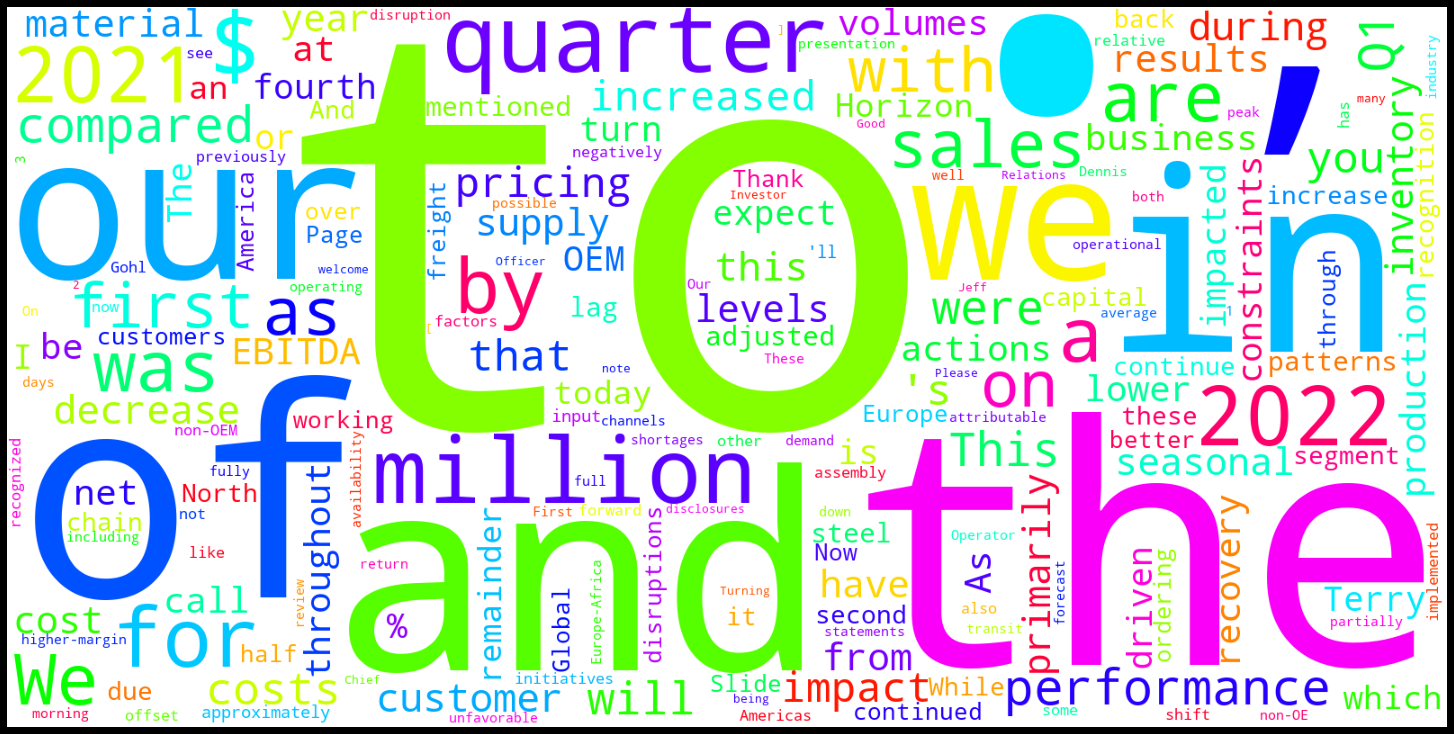

In [54]:
from collections import Counter
dictionary=Counter(tokens_)
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Read the whole text.
wordcloud = WordCloud(width=1600, height=800, colormap="hsv", background_color='white').generate_from_frequencies(dictionary)
# Open a plot of the generated image.

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('imagedist.png')
plt.show()
